In [163]:
pip install tensorflow keras matplotlib numpy opencv-python


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [164]:
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [252]:
import os
import csv

def create_labels(image_folder, label):
    # Check if the file is empty to write header
    file_exists = os.path.isfile('labels.csv')
    
    with open('labels.csv', 'a', newline='') as file:
        writer = csv.writer(file)
        
        # Write the header if the file is empty
        if not file_exists or os.path.getsize('labels.csv') == 0:
            writer.writerow(['image', 'label'])
        
        for filename in os.listdir(image_folder):
            if filename.lower().endswith(('.jpg', '.png', '.jpeg')):
                writer.writerow([filename, label])

# Paths to your image folders
solar_farm_folder = '/Users/macbookpro/Desktop/SolarProject/SolarFarm_Images'
non_solar_farm_folder = '/Users/macbookpro/Desktop/SolarProject/Non_SolarFarms'

# Create labels
create_labels(solar_farm_folder, 1)  # Label 1 for solar farms
create_labels(non_solar_farm_folder, 0)  # Label 0 for non-solar farms


In [253]:
base_dir = '/Users/macbookpro/Desktop/SolarProject/dataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Create directories if they don't exist
os.makedirs(os.path.join(train_dir, 'solar_farm'), exist_ok=True)
os.makedirs(os.path.join(train_dir, 'non_solar_farm'), exist_ok=True)
os.makedirs(os.path.join(validation_dir, 'solar_farm'), exist_ok=True)
os.makedirs(os.path.join(validation_dir, 'non_solar_farm'), exist_ok=True)


In [254]:
df = pd.read_csv('labels.csv')
# Define function to split images into train and validation
# Paths to your image folders
solar_farm_folder = '/Users/macbookpro/Desktop/SolarProject/SolarFarm_Images'
non_solar_farm_folder = '/Users/macbookpro/Desktop/SolarProject/Non_SolarFarms'
def split_and_copy_images(df, img_folder, output_train_folder, output_validation_folder, test_size=0.2):
    # Split dataframe
    train_df, val_df = train_test_split(df, test_size=test_size, stratify=df['label'])
    
    # Copy images to respective directories
    for index, row in train_df.iterrows():
        src_path = os.path.join(img_folder, row['image'])
        # dest_path = os.path.join(output_train_folder, 'solar_farm' if row['label'] == 1 else 'non_solar_farm', row['image'])
        dest_path = output_train_folder
        shutil.copy(src_path, dest_path)
    
    for index, row in val_df.iterrows():
        src_path = os.path.join(img_folder, row['image'])
        #dest_path = os.path.join(output_validation_folder, 'solar_farm' if row['label'] == 1 else 'non_solar_farm', row['image'])
        dest_path = output_validation_folder
        shutil.copy(src_path, dest_path)

# Split and copy images
split_and_copy_images(df[df['label'] == 1], solar_farm_folder, os.path.join(train_dir, 'solar_farm'), os.path.join(validation_dir, 'solar_farm'))
split_and_copy_images(df[df['label'] == 0], non_solar_farm_folder, os.path.join(train_dir, 'non_solar_farm'), os.path.join(validation_dir, 'non_solar_farm'))

In [305]:
image_size = (150, 150)
batch_size =32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    # rotation_range=10,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    #zoom_range=(1.0, 1.2),
    # horizontal_flip=True,
    # fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=image_size,
    batch_size=15,
    class_mode='binary'
)

Found 185 images belonging to 2 classes.
Found 48 images belonging to 2 classes.


In [303]:
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.layers import Dropout
def create_cnn_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    layers.Dense(512, activation='relu'),
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

model = create_cnn_model()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [306]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples //15
)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 567ms/step - accuracy: 0.7056 - loss: 0.6449 - val_accuracy: 0.6444 - val_loss: 0.6354
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4800 - loss: 0.7799 - val_accuracy: 0.3333 - val_loss: 0.9757
Epoch 3/10


2024-07-24 12:01:00.381357: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-24 12:01:00.406140: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 503ms/step - accuracy: 0.5218 - loss: 0.7405 - val_accuracy: 0.6889 - val_loss: 0.5970
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7500 - loss: 0.5900 - val_accuracy: 1.0000 - val_loss: 0.6093
Epoch 5/10


2024-07-24 12:01:04.713893: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-24 12:01:04.740189: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 512ms/step - accuracy: 0.6369 - loss: 0.5822 - val_accuracy: 0.8222 - val_loss: 0.5521
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8438 - loss: 0.5231 - val_accuracy: 0.3333 - val_loss: 0.6980
Epoch 7/10


2024-07-24 12:01:09.162017: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-24 12:01:09.186336: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 587ms/step - accuracy: 0.6840 - loss: 0.5690 - val_accuracy: 0.8444 - val_loss: 0.5349
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9062 - loss: 0.4322 - val_accuracy: 0.6667 - val_loss: 0.3989
Epoch 9/10


2024-07-24 12:01:13.713253: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-24 12:01:13.739863: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 495ms/step - accuracy: 0.7761 - loss: 0.5094 - val_accuracy: 0.8889 - val_loss: 0.4711
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8750 - loss: 0.4197 - val_accuracy: 0.6667 - val_loss: 0.5836


2024-07-24 12:01:17.985592: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-24 12:01:18.017843: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [308]:
test_loss, test_acc = model.evaluate(validation_generator)
print(f'Test accuracy: {test_acc}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8706 - loss: 0.4734 
Test accuracy: 0.8541666865348816


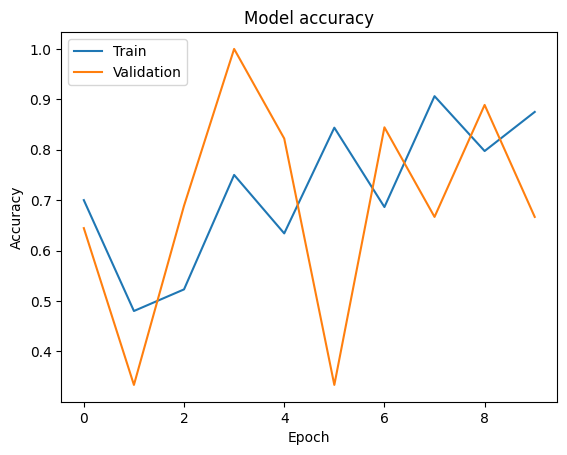

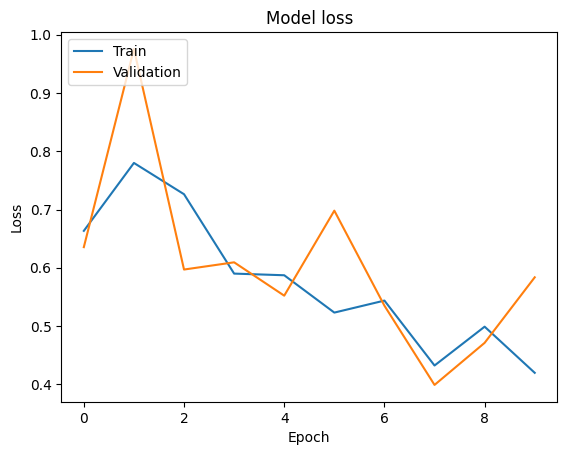

In [309]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
                precision    recall  f1-score   support

Non-Solar Farm       0.58      0.61      0.60        23
    Solar Farm       0.62      0.60      0.61        25

      accuracy                           0.60        48
     macro avg       0.60      0.60      0.60        48
  weighted avg       0.61      0.60      0.60        48



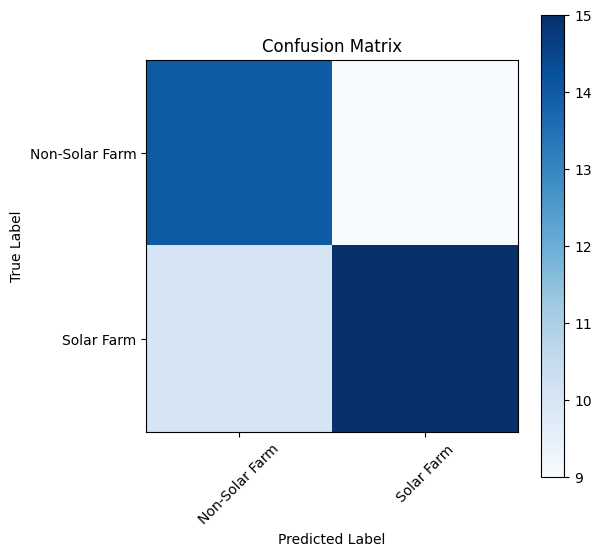

In [312]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get predictions
y_pred = model.predict(validation_generator)
y_pred = np.round(y_pred)  # Convert probabilities to binary predictions

# Get true labels
y_true = validation_generator.classes

# Print classification report
print(classification_report(y_true, y_pred, target_names=['Non-Solar Farm', 'Solar Farm']))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Non-Solar Farm', 'Solar Farm'], rotation=45)
plt.yticks(tick_marks, ['Non-Solar Farm', 'Solar Farm'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [313]:
model.save('solar_farm_model_best.h5')